###     Generating the Dataset

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters
n_users = 20  # Number of users
n_products = 10  # Number of products
n_ratings = 100  # Number of ratings

# Generate random user IDs and product IDs
user_ids = np.random.randint(1, n_users+1, size=n_ratings)
product_ids = np.random.randint(101, 101+n_products, size=n_ratings)

# Generate random ratings
ratings = np.random.randint(1, 6, size=n_ratings)

# Generate random timestamps within a specific month (e.g., September 2023)
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 30)
timestamps = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days)) for _ in range(n_ratings)]

# Create the DataFrame
data = pd.DataFrame({
    'user_id': user_ids,
    'product_id': product_ids,
    'rating': ratings,
    'timestamp': timestamps
})

# Save the dataset to a CSV file
data.to_csv('custom_ecommerce_data.csv', index=False)


### Loading and Preprocessing the Data 

In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv('custom_ecommerce_data.csv')

# Convert the timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Display basic statistics and check for missing values
print(data.describe())
print(data.isnull().sum())

# Drop any missing values (if any)
data.dropna(inplace=True)


          user_id  product_id      rating            timestamp
count  100.000000  100.000000  100.000000                  100
mean    10.190000  105.570000    3.020000  2023-09-16 03:07:12
min      1.000000  101.000000    1.000000  2023-09-01 00:00:00
25%      5.000000  103.000000    2.000000  2023-09-09 00:00:00
50%     10.000000  105.000000    3.000000  2023-09-17 00:00:00
75%     15.000000  108.000000    5.000000  2023-09-23 00:00:00
max     20.000000  110.000000    5.000000  2023-09-29 00:00:00
std      6.023011    3.078944    1.476961                  NaN
user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64


### Exploratory Data Analysis (EDA)

Number of unique users: 20
Number of unique products: 10


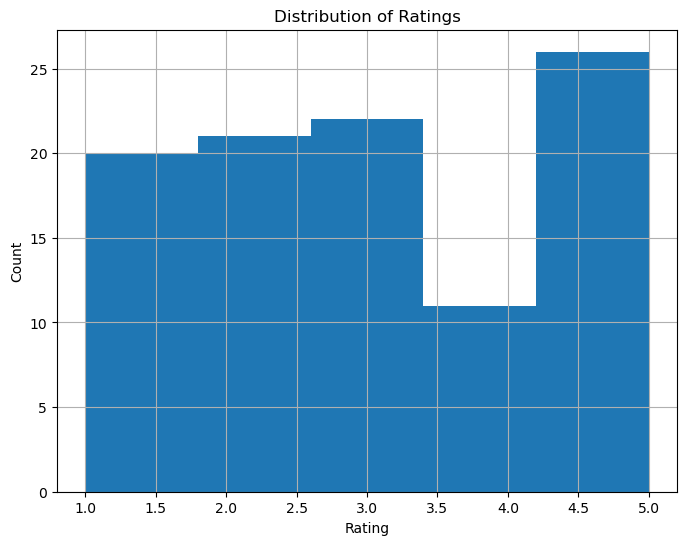

In [3]:
import matplotlib.pyplot as plt

# Number of unique users and products
unique_users = data['user_id'].nunique()
unique_products = data['product_id'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

# Distribution of ratings
plt.figure(figsize=(8, 6))
data['rating'].hist(bins=5)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### Building the Recommendation System


In [4]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Prepare data for the Surprise library
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(surprise_data, test_size=0.25)

# Initialize the SVD model
svd = SVD()

# Train the model
svd.fit(trainset)

# Make predictions on the test set
predictions = svd.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 1.4381
MAE:  1.1322
RMSE: 1.4381241379446874
MAE: 1.132232884201357


### Making Recommendations

In [5]:
from collections import defaultdict

def get_top_n_recommendations(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Get top 10 recommendations for all users
top_n = get_top_n_recommendations(predictions, n=10)

# Print recommendations for a specific user (e.g., user_id = 1)
print(f"Top 10 recommendations for user 1: {top_n[1]}")


Top 10 recommendations for user 1: [(103, 2.366241937646552)]


### Deploying the Model

In [6]:
import pickle

# Save the model
with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

# Load the model
with open('recommendation_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Make predictions with the loaded model
loaded_model.predict(uid=1, iid=101)


Prediction(uid=1, iid=101, r_ui=None, est=2.8862304105851644, details={'was_impossible': False})